# Импорт библиотек

In [1]:
import numpy as np
from PIL import Image, ImageFont
from pilmoji import Pilmoji
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# Методы для рисования

In [2]:
def color_diff(rgb1, rgb2):
    """Расстояние между двумя цветами"""
    return np.linalg.norm(rgb1 - rgb2)

In [3]:
def nearest_emoji(rgb, emoji_dict):
    """Найти ближайший по цвету смайлик"""
    return min(emoji_dict.keys(), 
               key=lambda k: color_diff(rgb, emoji_dict[k]))

In [4]:
def compare_images(images, labels):
    """Посмотреть две картинки рядом"""
    fig, axes = plt.subplots(ncols=2, dpi=300)
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img)
        ax.set_title(label)
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    plt.show()

In [5]:
def draw_emojis(filename, width, emoji_dict, disp=True):
    """
    Нарисовать картинку из смайликов-квадратов

    PARAMETERS
    ----------
    filename : str
        | название файла картинки, лежащей в папке input/, 
          которую необходимо нарисовать в виде смайликов
    
    width : int
        | ширина итоговой картинки из смайликов

    emoji_dict : dict
        | специальный словарь смайликов, где каждому
          смайлику соответствует назначенный ему цвет
          в формате numpy-массива из трех значений (RGB)
    
    disp : bool
        | отображать ли результат и логи
    
    RETURNS
    -------
    emoji_array : ndarray[str]
        | картинка из смайликов в виде 2D numpy-массива
    """
    # Загрузка картинки и преобразование в numpy array
    image = np.array(Image.open(f'input/{filename}'))
    # Сохранение только трех каналов под R, G, B
    image = image[:, :, :3]
    
    # Размеры картинки
    img_h, img_w, _ = image.shape
    # Размер блока, который заменится смайликом
    block_size = img_w // width
    
    # Размеры картины из смайликов
    w_quantity = width
    h_quantity = int(img_h / img_w * w_quantity)
    
    # Вывод размеров картинки
    if disp:
        print(f'Исходная картинка: {img_h}x{img_w}')
        print(f'Из смайликов:      {h_quantity}x{w_quantity}')
    
    # Уменьшенная версия картинки (сжатая)
    small_image = np.zeros((h_quantity, w_quantity, 3), dtype=int)
    # Ближайшая по цветам к смайликам версия картинки
    emoji_image = np.zeros((h_quantity, w_quantity, 3), dtype=int)
    # Массив из смайликов
    emoji_array = np.full((h_quantity, w_quantity), '', dtype='<U2')

    # i, j - индексы в сжатой картинке
    # h, w - соответствующие индексы в оригинальной картинке
    for i in range(h_quantity):
        for j in range(w_quantity):
            h = i * block_size
            w = j * block_size
            # Средний цвет по блоку
            avg_color = image[h:h+block_size, w:w+block_size].mean(axis=(0, 1))
            # Добавление нового смайлика в массив
            emoji = nearest_emoji(avg_color, emoji_dict)
            emoji_array[i, j] = emoji
            # Запись пикселя со средним цветом в уменьшенные картинки
            small_image[i, j] = np.rint(avg_color)
            emoji_image[i, j] = np.rint(emoji_dict[emoji])
    
    # Вывод результатов
    if disp:
        compare_images(images=(small_image, emoji_image), 
                       labels=('Уменьшенное разрешение', 
                               'Ближайшие к смайликам цвета'))

    return emoji_array

In [6]:
def load_emoji_dict(name):
    """
    Загрузить словарь смайликов из папки emoji_dicts/
    по его названию
    """
    with open(f'emoji_dicts/{name}.pkl', 'rb') as file:
        emoji_dict = pickle.load(file)
    return emoji_dict

In [7]:
def save_as_text(emoji_array, image_name):
    """
    Сохранить результат (массив смайликов) в файл
    в виде текста

    PARAMETERS
    ----------
    emoji_array : ndarray[str]
        | 2D numpy-массив из смайликов
    
    image_name : str
        | название картинки, текстовый файл для 
          которой будет сохранен в папку output/
    """
    with open(f'output/{image_name}.txt', 'w') as file:
        as_string = '\n'.join(''.join(line) 
                              for line in emoji_array)
        file.write(as_string)

In [8]:
def save_as_image(emoji_array, image_name, emoji_resolution, 
                  background_color=(0, 0, 0)):
    """
    Сохранить результат (массив смайликов) в файл
    в виде картинки формата PNG

    PARAMETERS
    ----------
    emoji_array : ndarray[str]
        | 2D numpy-массив из смайликов
    
    image_name : str
        | название картинки, png-файл для 
          которой будет сохранен в папку output/

    emoji_resolution : int
        | размер каждого смайлика на итоговой картинке
          в пикселях (каждый смайлик рисуется в квадратной 
          области, и этот параметр задает сторону квадрата)

    background_color : (int, int, int)
        | цвет фона картинки в формате RGB
    """
    # Высота и ширина массива из смайликов
    emojis_h, emojis_w = emoji_array.shape
    # Высота и ширина итоговой картинки из смайликов
    img_h, img_w = np.array(emoji_array.shape) * emoji_resolution
    
    # Создание картинки из смайликов
    with Image.new('RGB', (img_w, img_h), background_color) as image:
        # Шрифт для отображения смайликов
        font = ImageFont.truetype('fonts/arial.ttf', emoji_resolution)
        # Рисование смайликов на картинке
        with Pilmoji(image) as pilmoji:
            for i in range(emojis_w):
                for j in range(emojis_h):
                    # Индексы пикселей в итоговой картинке
                    w, h = i * emoji_resolution, j * emoji_resolution
                    pilmoji.text((w, h), emoji_array[j, i], font=font)

    image.save(f'output/{image_name}.png')

# Рисование

Исходная картинка: 1080x1080
Из смайликов:      50x50


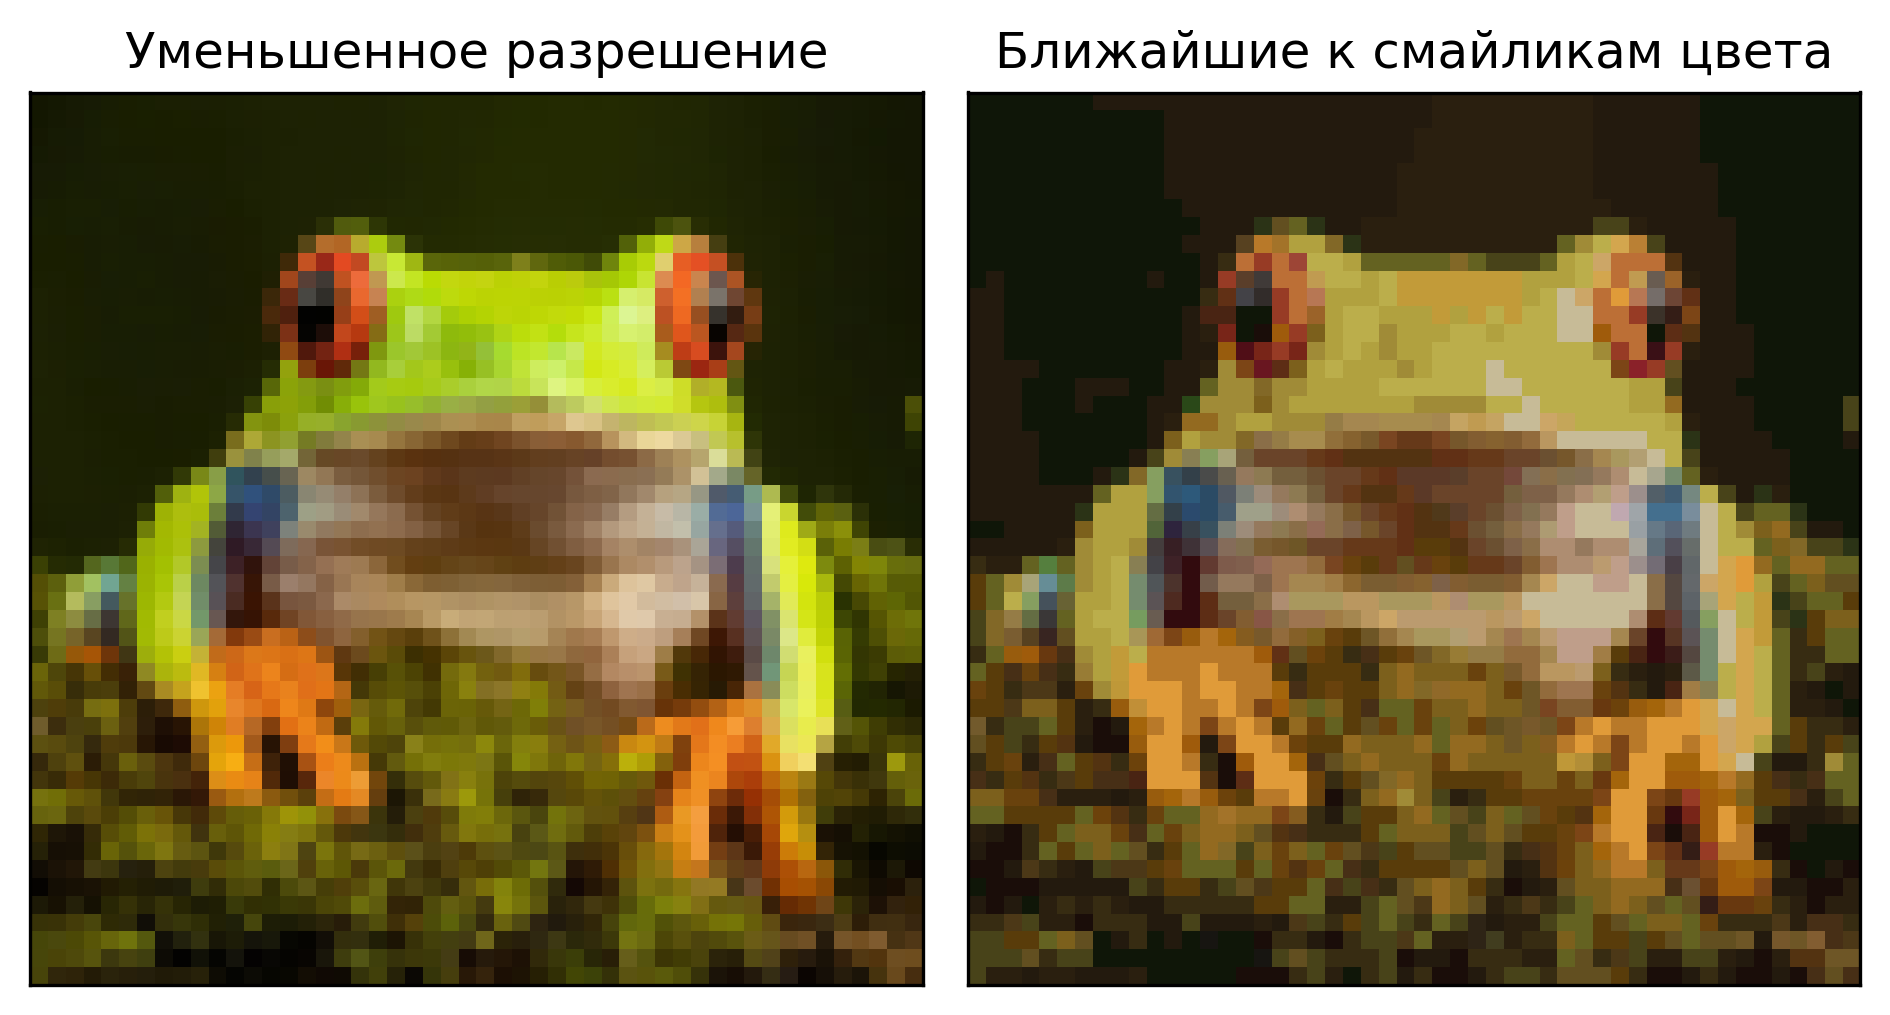

Результаты сохранены в папку output/
CPU times: user 7.87 s, sys: 350 ms, total: 8.22 s
Wall time: 26 s


In [9]:
%%time

# Рисование
result = draw_emojis(filename='frog.png', 
                     width=50, 
                     emoji_dict=load_emoji_dict('classic_black'))

# Сохранение результата
save_as_text(result, 'frog')
save_as_image(result, 'frog', 
              emoji_resolution=50, 
              background_color=(0, 0, 0))

print('Результаты сохранены в папку output/')